In [1]:
# general purpose data manipulation and analysis
import numpy as np
import scipy.spatial as spatial

# packages for working with raster datasets
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.enums import Resampling

import xarray # allows us to work with raster data as arrays

# packages for working with geospatial data
!pip install pycrs
import geopandas as gpd
import pycrs

from shapely.geometry import box

# import packages for viewing the data
import matplotlib.pyplot as pyplot


In [2]:
#define paths
import os
CURDIR = os.path.dirname(os.path.realpath("__file__"))

In [3]:
# matplotlib functionality
%matplotlib inline
# %matplotlib notebook

## Canopy height models

We will use an existing raster of a canopy height model (CHM) to clip our snow depth map. This CHM is an area investigated by [Mazzotti et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019WR024898). You can also access the data [here](https://www.envidat.ch/#/metadata/als-based-snow-depth).

In [4]:
# load the chm
chmc = xarray.open_rasterio('/home/jovyan/website/book/tutorials/lidar/data/CHM_20160926GMc_700x700_EPSG32612.tif')
chmb = xarray.open_rasterio('/home/jovyan/website/book/tutorials/lidar/data/CHM_20160926GMb_700x700_EPSG32612.tif')

#chm2 = rasterio.open('/home/jovyan/website/book/tutorials/lidar/data/CHM_20160926GMb_700x700_EPSG32612.tif')

In [5]:
# check the crs is the same as the snow depth data
chmc.crs
#chm2.crs
#chm2?
#chmc?

'+init=epsg:32612'

Don't forget that if the coordinate systems in your datasets don't match then you will need to transform one of them. You can change the coordinate systems using the links above. (Note, I've already transformed this dataset from EPSG 32613).

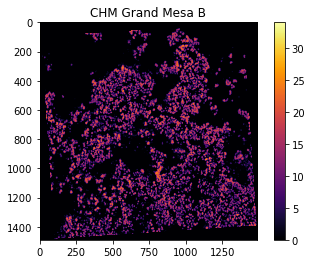

In [6]:
# plot the CHM, setting the maximum color value to the maximum canopy height in the dataset
fig3, ax3 = pyplot.subplots()
pos3 = ax3.imshow(chmc.data[0,:,:], cmap='inferno', vmin=0, vmax=chmb.data.max())
ax3.set_title('CHM Grand Mesa B')
fig3.colorbar(pos3, ax=ax3)

### Canopy Density
Canopy density metric defined as the proportion of first returns whose height is 2 meters or greater divided by the total number first returns (0.0 to 1.0). 

[Canopy Fuel Estimator (CFE)](http://forsys.cfr.washington.edu/CFE/canopy_fuel_estimator.html)

**Method**

We use a kdtree searcher with a 5 m radius to estimate the CFE

In [7]:
# Compute the CFE or Load a previously computed .tif
# Compute time is approx 15 minutes
isC = 1
isB = 0
if isC:
    cfe = chmc
    chm = chmc
elif isB:
    cfe = chmb
    chm = chmb
isKDTree = 1
if isKDTree:
    y = cfe.y.values
    x = cfe.x.values
    yyix = range(len(y))
    xxix = range(len(x))
    xv,yv = np.meshgrid(x,y,sparse=False, indexing = 'xy')
    xixv,yixv = np.meshgrid(xxix,yyix,sparse=False, indexing = 'xy')
    xv = np.reshape(xv,-1)
    yv = np.reshape(yv,-1)
    xixv = np.reshape(xixv,-1)
    yixv = np.reshape(yixv,-1)
    coords = np.column_stack([xv,yv])
    mytree = spatial.cKDTree(coords)
    radius = 5
    #ix = mytree.query_ball_point(point, 5,return_sorted=None, return_length=False)
    #print(ix)
    for jj in range(len(yv)):
        point = [xv[jj],yv[jj]]
        ix = mytree.query_ball_point(point, radius,return_sorted=None, return_length=False)
        # Compute the CFE and Store it into our xarray
        yix,xix = np.unravel_index(ix,[len(cfe.y.values),len(cfe.x.values)])
        tmpix1 = np.argwhere(chm.data[0,yix,xix]>=2)
        tmpix2 = np.argwhere(chm.data[0,yix,xix]<2)
        # Must check if empty
        if not len(tmpix1):
            cfe.data[0,yixv[jj],xixv[jj]] = 0
        else:    
            cfe.data[0,yixv[jj],xixv[jj]] = len(tmpix1)/(len(tmpix1)+len(tmpix2))
        # This loop is if we want to do other stats with the searched data
            #bin = []
            #for kk in range(len(tmp)):
            #    tmpix1 = tmpix1[kk][0]
            #    tmpix2 = tmpix1[kk][1]
            #    bin.append(chmb.data[0][tmpix1][tmpix2])
else: # Load .tif Imagery
    if isB:
        in_tif = "/home/jovyan/snow-sinking/data/CFE_20160926GMb_700x700_EPSG32612.tif"
    if isC:
        in_tif = "/home/jovyan/snow-sinking/data/CFE_20160926GMc_700x700_EPSG32612.tif"
    cfe= xarray.open_rasterio(in_tif)

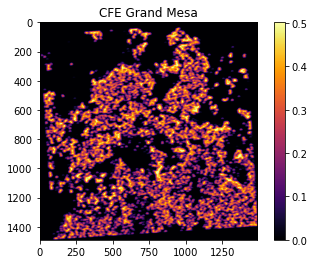

In [8]:
# plot the CFE, setting the maximum color value to the maximum canopy height in the dataset
fig3, ax3 = pyplot.subplots()
pos3 = ax3.imshow(cfe.data[0,:,:], cmap='inferno', vmin=0, vmax=cfe.data.max())
ax3.set_title('CFE Grand Mesa')
fig3.colorbar(pos3, ax=ax3)

In [9]:
if isKDTree:
    epsg_code = int(cfe.crs[11:])
    out_meta= ({"driver": "GTiff","dtype": "float32", 'nodata': -3.4028230607370965e+38, "width": cfe.shape[2],"height": cfe.shape[1],"count": 1, "transform": cfe.transform,"crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

In [10]:
if isB:
    out_tif = "/home/jovyan/snow-sinking/data/CFE_20160926GMb_700x700_EPSG32612.tif"
if isC:
    out_tif = "/home/jovyan/snow-sinking/data/CFE_20160926GMc_700x700_EPSG32612.tif"
    
isWrite = 1    
if isWrite:
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(cfe.data)

In [11]:
CFE = xarray.open_rasterio(out_tif)
CFE.coords

Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.323e+06 4.323e+06 4.323e+06 ... 4.322e+06 4.322e+06
  * x        (x) float64 7.543e+05 7.543e+05 7.543e+05 ... 7.55e+05 7.55e+05

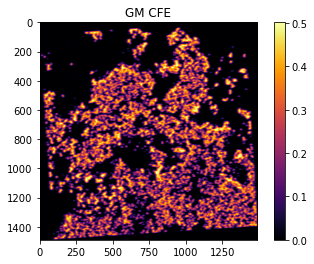

In [12]:
# plot the new SD map 
fig4, ax4 = pyplot.subplots()
pos4 = ax4.imshow(CFE.data[0,:,:], cmap='inferno', vmin=0, vmax=np.max(CFE.data))
ax4.set_title('GM CFE')
fig4.colorbar(pos4, ax=ax4)

In [13]:
cfe.crs

'+init=epsg:32612'